# Likelihood evaluations for Palanque-Delabrouille et al. (2013)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import sys
import os
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 180
mpl.rcParams['figure.dpi'] = 180
# our own modules
import simplest_emulator
import linear_emulator
import gp_emulator
import data_PD2013
import mean_flux_model
import thermal_model
import camb_cosmo
import fit_linP
import likelihood
import lya_theory

### Specify suite of simulations to use, read P1D arxiv and setup simplest emulator

In [2]:
basedir='../../p1d_emulator/sim_suites/emulator_15052019/'
p1d_label='p1d'
skewers_label='Ns110_wM0.1'
use_gp=True
if use_gp:
    emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,max_arxiv_size=1000,verbose=True,paramList=None,kmax_Mpc=5,train=True)
else:
    emu=linear_emulator.LinearEmulator(basedir,p1d_label,skewers_label,drop_tau_rescalings=False,drop_temp_rescalings=False,verbose=True)

latin hyper-cube data {'param_space': {'Om_star': {'ip': 0, 'min_val': 0.955, 'max_val': 0.975, 'z_star': 3.0, 'latex': '$\\Omega_\\star$'}, 'Delta2_star': {'ip': 1, 'min_val': 0.25, 'max_val': 0.45, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$\\Delta^2_\\star$'}, 'n_star': {'ip': 2, 'min_val': -2.35, 'max_val': -2.25, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$n_\\star$'}, 'alpha_star': {'ip': 3, 'min_val': -0.265, 'max_val': -0.165, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$\\alpha_\\star$'}, 'mu_He': {'ip': 4, 'min_val': 0.5, 'max_val': 2.0, 'latex': '$\\mu_{\\rm He}$'}, 'mu_H': {'ip': 5, 'min_val': 0.5, 'max_val': 2.0, '   latex': '$\\mu_{\\rm H}$'}}, 'nsamples': 10, 'samples': {'0': [0.96, 0.32, -2.325, -0.22, 0.875, 1.7750000000000001], '1': [0.966, 0.4, -2.295, -0.23, 1.175, 0.575], '2': [0.968, 0.36, -2.285, -0.26, 1.7750000000000001, 1.625], '3': [0.97, 0.3, -2.315, -0.18, 1.3250000000000002, 1.3250000000000002], '4': [0.974, 0.34, -2.305, -0.21000000000000002, 1.475, 1.175], '5': [

### Read P1D data from Palanque-Delabrouille et al. (2013)

In [3]:
basedir='../../p1d_data/data_files/PD2013/'
data=data_PD2013.P1D_PD2013(basedir=basedir,blind_data=False)
zs=data.z
Nz=len(zs)

### Setup nuisance models

In [4]:
mf_model=mean_flux_model.MeanFluxModel()
T_model=thermal_model.ThermalModel()

In [5]:
z=3.4
print('<F>(z=%.2f) = %f'%(z,mf_model.get_mean_flux(z)))
print('T_0(z=%.2f) = %f'%(z,T_model.get_T0(z)))
print('gamma(z=%.2f) = %f'%(z,T_model.get_gamma(z)))

<F>(z=3.40) = 0.542421
T_0(z=3.40) = 10000.000000
gamma(z=3.40) = 1.400000


### Setup cosmological model

Can run the code starting from an actual cosmological model (from CAMB) or from a set of linP parameters

In [6]:
# compute linear power parameters, around z_star and kp_kms
z_star=3.0
kp_kms=0.009
use_linP_params=True
if use_linP_params:
    linP_params={'f_star': 0.97664687870657374, 'g_star': 0.9709060615373754,
                 'Delta2_star': 0.35998124879741872, 'n_star': -2.3003810483122491,
                 'alpha_star': -0.2160018587455611}
    linP_model=fit_linP.LinearPowerModel(params=linP_params,z_star=z_star,k_units='kms',kp=kp_kms)
else:
    # specify cosmology
    cosmo = camb_cosmo.get_cosmology(mnu=0.15,As=2.2e-9,H0=65.0)
    # print relevant information about the cosmology object
    camb_cosmo.print_info(cosmo)
    # parameterize cosmology
    linP_model=fit_linP.LinearPowerModel(cosmo=cosmo,z_star=z_star,k_units='kms',kp=kp_kms)
    linP_params=linP_model.get_params()
    print('linP_params',linP_params)

### Setup Lyman alpha theory

In [7]:
theory = lya_theory.LyaTheory(zs,emulator=emu,verbose=False)

Note: redshifts have been re-sorted (earliest first)


In [8]:
theory.set_cosmo_model(linP_model)
theory.set_mf_model(mf_model)
theory.set_T_model(T_model)

In [9]:
# emulate P1D for all redshifts
k_kms=data.k
emu_p1d_kms=theory.get_p1d_kms(k_kms)

Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box


### Compare emulator calls to models in arxiv, for all redhsifts

In [10]:
like=likelihood.Likelihood(data=data,theory=theory)
like.go_silent()

likelihood setup with 1 free parameters
1 free parameters


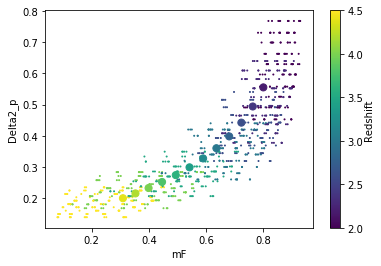

In [11]:
like.overplot_emulator_calls('mF','Delta2_p',tau_scalings=True)

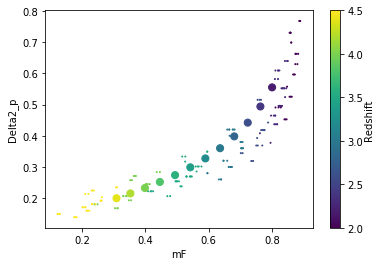

In [12]:
like.overplot_emulator_calls('mF','Delta2_p',tau_scalings=False)

### For each redshift, plot data vs model

Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box


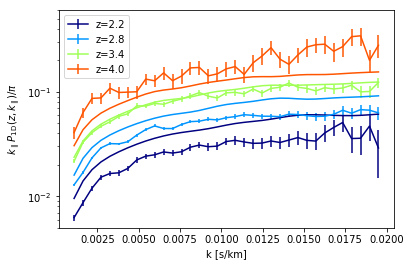

In [13]:
like.plot_p1d()

### Plot chi2 vs mean optical depth parameter

In [14]:
chi2=like.get_chi2()
print('chi2 =',chi2)

Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
chi2 = 14671.095517731923


In [15]:
len(like.theory.emulator.arxiv.data)

1000

In [16]:
# effective optical depth at z=3
tau_0 = np.linspace(0.3,0.55,50)
Ntau=len(tau_0)

In [17]:
chi2_tau=np.empty(Ntau)
for i in range(Ntau):
    mf_model=mean_flux_model.MeanFluxModel(z_tau=3.0,ln_tau_coeff=[3.2, np.log(tau_0[i])])
    like.theory.set_mf_model(mf_model)
    chi2_tau[i] =like.get_chi2()
    #print(i,tau_0[i],np.exp(-tau_0[i]),'chi2 =',chi2_tau[i])

Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower tha

Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower tha

Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower tha

Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower than k_box
Warning! Your requested k bins contain values lower tha

Text(0, 0.5, '$\\chi^2$')

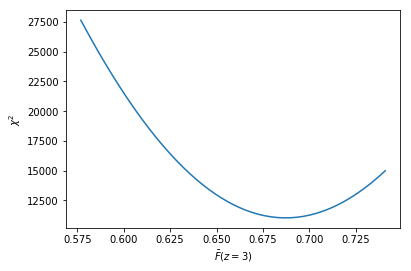

In [18]:
plt.plot(np.exp(-tau_0),chi2_tau)
plt.xlabel(r'$\bar F(z=3)$')
plt.ylabel(r'$\chi^2$')